## Tutorial: Multi-Energy refinement

It is often advantageous to refine reflectivity measured at multiple photon energies simultaneously in order to determine a unique model. The intrinsic contrast afforded at resonance allows for simple global fits for improved model uniqueness. This tutorial will present a suitable method to simultaneously refine datasets taken across multiple energies on a single sample.

### Initialize PyPXR
We begin by initializing the same modules for fitting polarized reflectivity as stated in the first tutorial. 
The only new function required is `GlobalObjective` that will allow for simultaneous model refinement

In [1]:
%matplotlib inline

import os.path
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py

sys.path.append("../../../src/PyPXR") # Temporary solution until hosted on pip

from reflectivity import *
from structure import *

# For Fitting
from refnx.dataset import ReflectDataset # Object used to define data
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective

PyPXR provides two datasets for this example measured on the same sample

In [2]:
mypath = "../../../src/PyPXR/example_data/"
# Energy 1 - 284.7 eV
data_spol_en1 = os.path.join(mypath, 'Feb19_Exp101_p100.txt')  # s-pol data
data_ppol_en1 = os.path.join(mypath, 'Feb19_Exp101_p190.txt')  # p-pol data
mydata_s1 = np.genfromtxt(data_spol_en1, delimiter='\t')
mydata_p1 = np.genfromtxt(data_ppol_en1, delimiter='\t')

# Energy 2 - 285.7 eV
data_spol_en2 = os.path.join(mypath, 'Feb19_Exp102_p100.txt')  # s-pol data
data_ppol_en2 = os.path.join(mypath, 'Feb19_Exp102_p190.txt')  # p-pol data
mydata_s2 = np.genfromtxt(data_spol_en2, delimiter='\t')
mydata_p2 = np.genfromtxt(data_ppol_en2, delimiter='\t')

# Concatenate spol / ppol data together for fitting
mydata_en1 = np.concatenate([mydata_s1, mydata_p1])
mydata_en2 = np.concatenate([mydata_s2, mydata_p2])

# Construct objects to use refnx fitting modules, a Transpose is called to set the axis correctly
data_en1 = ReflectDataset(mydata_en1.T)
data_en2 = ReflectDataset(mydata_en2.T)


To initiate multi-energy model refinement we will utilize a combination of two strategies:

1) Shared `PXR_Slab` objects that are identical between data-sets. Properties can be determined through an input energy.

2) A series of inter-slab constraints that allow us to ensure identical structural parameters (thickness, roughness, etc.)

### Create models for each dataset.

In [3]:
# List of energies associated with each dataset
# en1 = 284.7 eV
# en2 = 285.7 ev
en_list = [284.7, 285.7] #[eV]

# Substrate / Superstrate objects
# These objects will be used in both structures 
si = PXR_MaterialSLD('Si', density=2.33, name='Si') #Substrate
sio2 = PXR_MaterialSLD('SiO2', density=2.28, name='SiO2') #Substrate
vacuum = PXR_MaterialSLD('', density=1, name='vacuum') #Superstrate

# Slabs for each material
si_slab = si(0, 0.5) #thickness of bounding substrate does not matter
sio2_slab = sio2(12, 1)

We did not specify a photon energy for these `PXR_MaterialSLD` items. 
When we call `PXR_ReflectModel` it will update the structure based on the input energy. This allows us to use a single slab object for both structures.

#### Build energy-dependent structure components
We now want to craft four `PXR_SLD` objects (2 layers x 2 energies) with uniaxial optical parameters.

In [4]:
# Energy 1
# Bulk object
n_xx1 = complex(-0.00043, 0.0001) # [unitless] #Ordinary Axis
n_zz1 = complex(-0.00049, 0.00019) # [unitless] #Extraordinary Axis
posa_en1 = PXR_SLD(np.array([n_xx1, n_zz1]), name='posa1') #Molecule
# Surface objet
n_xx1 = complex(-0.00019, 0.00152) # [unitless] #Ordinary Axis
n_zz1 = complex(-0.00020, 0.00001) # [unitless] #Extraordinary Axis
posa_surface_en1 = PXR_SLD(np.array([n_xx1, n_zz1]), name='posa1_surf') #Molecule

posa_slab_en1 = posa_en1(711, 1) # Bulk Slab
posa_surface_slab_en1 = posa_surface_en1(20,1) # Surface Slab

# Energy 2
# Bulk object
n_xx2 = complex(0.00097, 0.0007) # [unitless] #Ordinary Axis
n_zz2 = complex(0.00120, 0.0007) # [unitless] #Extraordinary Axis
posa_en2 = PXR_SLD(np.array([n_xx2, n_zz2]), name='posa2') #Molecule
# Surface objet
n_xx2 = complex(0.00146579, 0.00001) # [unitless] #Ordinary Axis
n_zz2 = complex(0.00061, 0.00050) # [unitless] #Extraordinary Axis
posa_surface_en2 = PXR_SLD(np.array([n_xx2, n_zz2]), name='posa2_surf') #Molecule

posa_slab_en2 = posa_en2(711, 1) # Bulk Slab
posa_surface_slab_en2 = posa_surface_en2(20,1) # Surface Slab

In [5]:
# Build structures for each energy independently
# Note: vacuum, sio2_slab, and si_slab objects are the same in both structures!

structure_en1 = vacuum | posa_surface_slab_en1 | posa_slab_en1 | sio2_slab | si_slab
structure_en2 = vacuum | posa_surface_slab_en2 | posa_slab_en2 | sio2_slab | si_slab

#### Making a multi-energy objective function
We now use our individual structures to create a full objective function to be fit.

At this point, we want to specify  photon energies for each `PXR_ReflectModel`. This will use the PeriodicTable python package to extract n(E) for non-resonant `PXR_MaterialSLD` objects.

In [6]:
# Models
# pol specifies order of concatenated polarizations
model_en1 = PXR_ReflectModel(structure_en1, energy=en_list[0], pol='sp')
model_en2 = PXR_ReflectModel(structure_en2, energy=en_list[1], pol='sp')

obj_en1 = Objective(model_en1, data_en1, transform=Transform('logY'))
obj_en2 = Objective(model_en2, data_en2, transform=Transform('logY'))

A `GlobalObjective` combines individual `Objective` objects to simultaneously fit both models.

In [7]:
objective = GlobalObjective([obj_en1, obj_en2]) 

### Enforce inter-energy constraints
We are almost ready to fit. We now want to create a series of inter-energy constaints for several parameters. 

There are many ways to do this, the following is a brute force method that should make the ideas clear. Please see the example run file for a more advanced method that is more efficient at fitting more than two energies.

In [8]:
# Substrate parameters are shared between structures and do not need to be constrained.
si_slab.thick.setp(vary=False)
si_slab.rough.setp(vary=False, bounds=(1,2))

sio2_slab.thick.setp(vary=False, bounds=(5,20))
sio2_slab.rough.setp(vary=True, bounds=(1,10))
sio2_slab.sld.density.setp(vary=False)

# The default tensor symmetry is uniaxial.
# This automatically sets constraints for xx = yy and ixx = iyy
posa_slab_en1.thick.setp(vary=True, bounds=(400,900))
posa_slab_en1.rough.setp(vary=True, bounds=(0.2,20))
posa_slab_en1.sld.xx.setp(vary=True, bounds=(-0.01, -0.0000001)) # We know this is negative from NEXAFS
posa_slab_en1.sld.zz.setp(vary=True, bounds=(-0.01, -0.0000001)) # We know this is negative from NEXAFS
posa_slab_en1.sld.ixx.setp(vary=True, bounds=(0, 0.01))
posa_slab_en1.sld.izz.setp(vary=True, bounds=(0, 0.01))

posa_surface_slab_en1.thick.setp(vary=True, bounds=(5,30))
posa_surface_slab_en1.rough.setp(vary=True, bounds=(0.5,20))
posa_surface_slab_en1.sld.xx.setp(vary=True, bounds=(-0.1, -0.0000001)) # We know this is negative from NEXAFS
posa_surface_slab_en1.sld.zz.setp(vary=True, bounds=(-0.1, -0.0000001)) # We know this is negative from NEXAFS
posa_surface_slab_en1.sld.ixx.setp(vary=True, bounds=(0, 0.01))
posa_surface_slab_en1.sld.izz.setp(vary=True, bounds=(0, 0.01))

# The default tensor symmetry is for uniaxial materials.
# This automatically sets constraints for xx = yy and ixx = iyy
posa_slab_en2.thick.setp(vary=None, constraint=posa_slab_en1.thick) #'vary' must be set to None to use constraint
posa_slab_en2.rough.setp(vary=None, constraint=posa_slab_en1.rough)
#posa_slab_en2.thick.setp(vary=True, bounds=(400,900))
#posa_slab_en2.rough.setp(vary=True, bounds=(0.2,20))
posa_slab_en2.sld.xx.setp(vary=True, bounds=(-0.01, 0.01))
posa_slab_en2.sld.zz.setp(vary=True, bounds=(-0.01, 0.01))
posa_slab_en2.sld.ixx.setp(vary=True, bounds=(0, 0.01))
posa_slab_en2.sld.izz.setp(vary=True, bounds=(0, 0.01))

posa_surface_slab_en2.thick.setp(vary=None, constraint=posa_surface_slab_en1.thick)
posa_surface_slab_en2.rough.setp(vary=None, constraint=posa_surface_slab_en1.rough)
#posa_surface_slab_en2.thick.setp(vary=True, bounds=(5,30))
#posa_surface_slab_en2.rough.setp(vary=True, bounds=(0.2,20))
posa_surface_slab_en2.sld.xx.setp(vary=True, bounds=(-0.01, 0.01))
posa_surface_slab_en2.sld.zz.setp(vary=True, bounds=(-0.01, 0.01))
posa_surface_slab_en2.sld.ixx.setp(vary=True, bounds=(0, 0.01))
posa_surface_slab_en2.sld.izz.setp(vary=True, bounds=(0, 0.01))


In [9]:
fitter = CurveFitter(objective, nwalkers=200)#, pool=8) # pool is used to set the number of processers
# Optional change to the initialization. Offset chains from initial conditions
fitter.initialise(pos='jitter')

In [10]:
# First set of samples finds the local minima, In this example we assume this 
chain = fitter.sample(10000, random_state=246681) # seed random number generator for repeatability
fitter.reset() #Burn away the initial search
chain = fitter.sample(5000, random_state=991166) # Explore the posterior distribution

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [16:10<00:00,  5.15it/s]


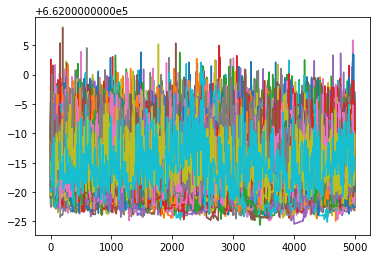

In [11]:
# Verify that the chains have reached a minima
lp = fitter.logpost
fig = plt.plot(-lp)

### Check on the final results

Each objective and structure can now be plotted to look at the final result.

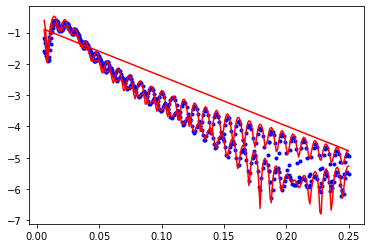

In [12]:
obj1 = obj_en1.plot()

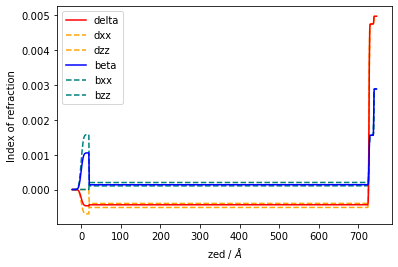

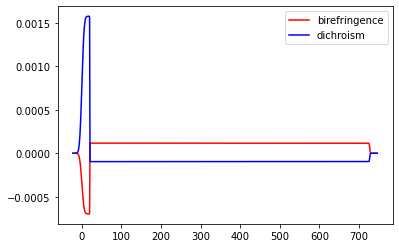

In [13]:
struct_en1 = structure_en1.plot(difference=True) # Depth profile w/ orientation

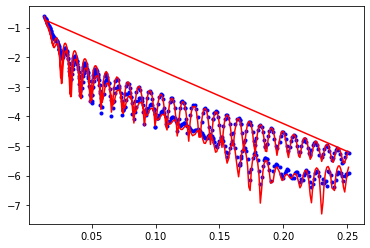

In [14]:
obj2 = obj_en2.plot()

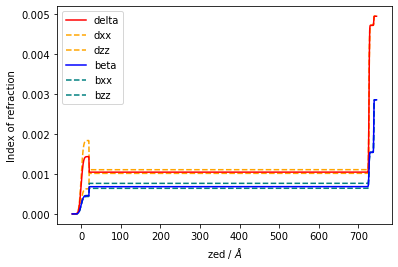

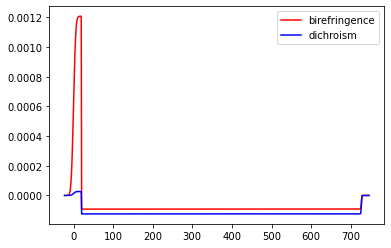

In [15]:
struct_en2 = structure_en2.plot(difference=True) # Depth profile w/ orientation

In [16]:
# Check on the final parameters
# Note that there is only one parameter for the roughness/thickness of each layer.
print(objective.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:'posa1_surf_thick', value=19.9505 +/- 0.012, bounds=[5.0, 30.0]>
<Parameter:'posa1_surf_xx', value=-0.000698515 +/- 4e-06, bounds=[-0.1, -1e-07]>
<Parameter:'posa1_surf_ixx', value=0.0015763 +/- 2.27e-06, bounds=[0.0, 0.01]>
<Parameter:'posa1_surf_zz', value=-2.02562e-07 +/- 1.24e-07, bounds=[-0.1, -1e-07]>
<Parameter:'posa1_surf_izz', value=5.06237e-08 +/- 6.02e-08, bounds=[0.0, 0.01]>
<Parameter:'posa1_surf_rough', value=4.40916 +/- 0.00994, bounds=[0.5, 20.0]>
<Parameter: 'posa1_thick' , value=706.954 +/- 0.0142, bounds=[400.0, 900.0]>
<Parameter:  'posa1_xx'   , value=-0.000398396 +/- 7.29e-07, bounds=[-0.01, -1e-07]>
<Parameter:  'posa1_ixx'  , value=0.000104594 +/- 2.4e-07, bounds=[0.0, 0.01]>
<Parameter:  'posa1_zz'   , value=-0.000514603 +/- 4.82e-07, bounds=[-0.01, -1e-07]>
<Parameter:  'posa1_izz'  , value=0.000201188 +/- 2.2e-07, bounds=[0.0, 0.01]>
<Parame